# ITALIAN to ENGLISH Dataset

Preprocessing of over 352 000 Italian-English sentence pairs: <br>
- tokenizing
- creating tensorflow datasets
- saving 


Data: https://www.manythings.org/anki/ita-eng.zip

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle as pkl

from keras import layers
import tensorflow.data

from sklearn.model_selection import train_test_split

In [2]:
PATH = '../Data/italian/ita.txt'
VOCAB_SIZE = 10000
MAX_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = 50000
AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

In [3]:
def load_sentences(path):
    english, italian = [], []
    
    with open(path, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            eng, ita = line.split('\t')[:2]
            english.append(eng)
            italian.append(ita)
    return english, italian


english_sents, italian_sents = load_sentences(PATH)

# add special tokens to english sentences
add_tokens = lambda x: 'ssss ' + x + ' eeee'
english_sents = list(map(add_tokens, english_sents))

# double check
assert len(english_sents) == len(italian_sents)

In [4]:
def filter_to_max_len(fr, eng, max_len):
    english, italian = [], []
    
    len_filter = lambda x: len(x.split(' ')) < MAX_LEN
    for e, i in zip(eng, fr):
        if len_filter(e) and len_filter(i):
            english.append(e)
            italian.append(i)
    return english, italian


# remove if greater than maxlen
english, italian = filter_to_max_len(italian_sents, english_sents, MAX_LEN)

In [5]:
print(f'Size before filtering:\t{len(english_sents)}')
print(f'Size after filtering:\t{len(english)}')

Size before filtering:	352894
Size after filtering:	352332


In [6]:
# vectorizers
ita_vectorizer = layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LEN
)

eng_vectorizer = layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_LEN + 1 # shifted inputs
)

ita_vectorizer.adapt(italian)
eng_vectorizer.adapt(english)

In [7]:
# convert sentences to arrays
italian_tokenized = ita_vectorizer(italian)
english_tokenized = eng_vectorizer(english)

print(f'italian shape:\t{italian_tokenized.shape}')
print(f'english shape:\t{english_tokenized.shape}')

italian shape:	(352332, 20)
english shape:	(352332, 21)


In [8]:
ita_train, ita_test, \
eng_train, eng_test = train_test_split(italian_tokenized.numpy(), 
                                       english_tokenized.numpy(), 
                                       train_size=0.7, 
                                       random_state=2018, 
                                       shuffle=True)

ita_val, ita_test, \
eng_val, eng_test = train_test_split(ita_test, eng_test, train_size=0.5, shuffle=False)

print(f'train size:\t{len(ita_train)}')
print(f'val size:\t{len(ita_val)}')
print(f'test size:\t{len(ita_test)}')

train size:	246632
val size:	52850
test size:	52850


In [9]:
def rename_data(ita, eng):
    return {'encoder_inputs': ita,
            'decoder_inputs': eng[:, :-1]}, \
            eng[:, 1:]


train_dict = rename_data(ita_train, eng_train)
val_dict   = rename_data(ita_val, eng_val)
test_dict  = rename_data(ita_test, eng_test)

In [39]:
def create_ds(data):
    return tensorflow.data.Dataset.from_tensor_slices((data[0], data[1])) \
                                    .cache()                \
                                    .shuffle(BUFFER_SIZE)   \
                                    .batch(BATCH_SIZE)      \
                                    .prefetch(AUTOTUNE)     

In [40]:
# train_ds = create_ds(train_dict)
# val_ds   = create_ds(val_dict)
test_ds  = create_ds(test_dict)

In [41]:
# functions to store and load datasets

def save_dataset(dataset, path):
    spec = dataset.element_spec
    tensorflow.data.experimental.save(dataset, path)
    name = path.split('/')[-1]
    
    # in order to load tf dataset we need to provide element_spec
    with open(f'{path}/{name}.pkl', 'wb') as file:
        pkl.dump(spec, file)
    
    
def load_dataset(path):
    name = path.split('/')[-1]
    with open(f'{path}/{name}.pkl', 'rb') as file:
        spec = pkl.load(file)
        
    dataset = tensorflow.data.experimental.load(path, element_spec=spec)
    return dataset

In [42]:
path = '../Data/italian/'

# save everything
save_dataset(train_ds, path + 'train_ds')
save_dataset(val_ds, path + 'val_ds')
save_dataset(test_ds, path + 'test_ds')


with open(path + 'test.pkl', 'wb') as file:
    pkl.dump(test_dict, file)

In [25]:
# save both vectorizers
# we will need them during inference

def save_vectorizer(path, vectorizer):
    pkl.dump({'config': vectorizer.get_config(),
              'weights': vectorizer.get_weights()}, 
              open(path, "wb"))
    

def load_vectorizer(path):
    with open(path, 'rb') as file:
        config = pkl.load(file)
        
    vec = layers.experimental.preprocessing.TextVectorization.from_config(config['config'])
    vec.adapt(['bugged so I have to adapt on dummy data'])
    vec.set_weights(config['weights'])
    return vec
    

save_vectorizer('../Vectorizers/vec_eng.pkl', eng_vectorizer)
save_vectorizer('../Vectorizers/vec_ita.pkl', ita_vectorizer)

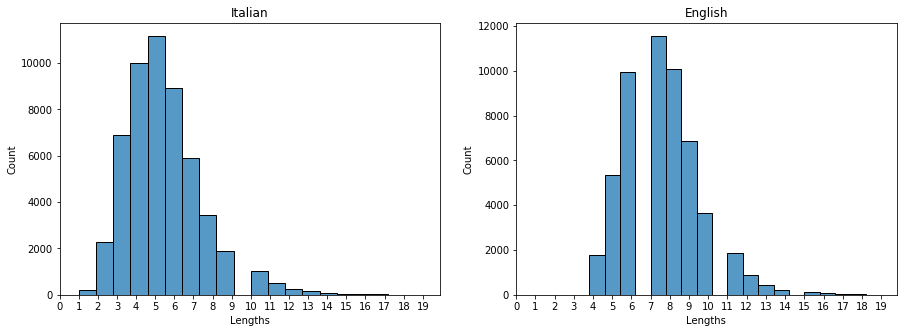

In [10]:
# just to get better knowledge of the data
def plot_lengths(data, ax, bins=MAX_LEN, title=''):
    lengths = np.count_nonzero(data, axis=-1)
    sns.histplot(lengths, ax=ax, bins=bins).set(xlabel='Lengths', title=title, xticks=list(range(bins)))
    
    
# merge all data dictionaries
dataset = train_dict[0].copy()
dataset.update(val_dict[0])
dataset.update(test_dict[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_lengths(dataset['encoder_inputs'], ax1, title='Italian')
plot_lengths(dataset['decoder_inputs'], ax2, title='English')